# Knee Frame Bracing Hysteresis Energy Optimisation

In [1]:
print('Link Hysteresis Energy optimization')

Link Hysteresis Energy optimization


In [36]:
import os
import sys
import comtypes.client
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pygad

import cProfile

In [11]:
SapObject = comtypes.client.GetActiveObject("CSI.SAP2000.API.SapObject")
SapModel = SapObject.SapModel
SapModel.SetModelIsLocked(False)

0

In [3]:
def link_option(Y_strength, L_name):
    """
    Modifies the yield strength for M3 of the selected link element
    Arguments:
        Y_strength: new yield strength
        L_name: Link name
    """
    DOF = [False, False, False, False, False, False]
    Fixed = [False, False, False, False, False, False]
    NonLinear = [False, False, False, False, False, False]
    Ke = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Ce = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    K =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Yield = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Ratio = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Exp =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

    DOF[0] = True
    Fixed[0] = True

    DOF[1] = True
    Fixed[1] = True

    DOF[2] = True
    Fixed[2] = True

    DOF[3] = True
    Fixed[3] = True

    DOF[3] = True
    Fixed[3] = True

    DOF[4] = True
    Fixed[4] = True

    DOF[5] = True
    NonLinear[5] = True
    Ke[5] = 100000
    Ce[5] = 0
    K[5] = 100000
    Yield[5] = Y_strength
    Ratio[5] = 0.03
    Exp[5] = 2
    ret = SapModel.PropLink.SetPlasticWen(L_name, DOF, Fixed, NonLinear, Ke, Ce, K, Yield, Ratio, Exp, 2, 0)
    ret = SapModel.PropLink.SetPDelta(L_name, [0.5, 0.5, 0.5, 0.5])

In [4]:
def cycle_number(result):
    """
    Calculates the number of load-unload cycles
    Arguments :
        result : pandas DataFrame with Force-Displacment results
    Returns :
        c : number of cycles
        result : modifies results DataFrame
    """
    result['q2'] = 0
    result['c'] = 0
    q1 = 0
    q2 = 0
    c = 0
    for i in range(len(result)-1):
        if result['Force'][i] >= 0.0 and result['Desplacment'][i] >= 0.0 : 
            q2 = 1
            result['q2'][i] = q2
        if result['Force'][i] < 0.0 and result['Desplacment'][i] > 0.0 : 
            q2 = 2
            result['q2'][i] = q2
        if result['Force'][i] < 0.0 and result['Desplacment'][i] < 0.0 : 
            q2 = 3
            result['q2'][i] = q2
        if result['Force'][i] > 0.0 and result['Desplacment'][i] < 0.0 : 
            q2 = 4
            result['q2'][i] = q2
        
        
        if q1 > q2 and q2 ==1:
            c += 1
        result['c'][i] = c

        q1 = q2
    return c, result


In [5]:
def Area(result):
    """
    Calculates the area under the function curve for a set of points using Trapezoidal rule
    Arguments : 
        result : DataFrame with the function data points
    Returns : 
        Energy : The area under the function curve
    """
    #Energy = np.abs(result['Desplacment'][len(result)-1]*result['Force'][0] - result['Desplacment'][0]*result['Force'][len(result)-1])/2
    Energy = 0
    for i in range(len(result)-1):
        #Area = result['Desplacment'][i]*result['Force'][i+1] - result['Desplacment'][i+1]*result['Force'][i]
        Area = (result['Force'][i] + result['Force'][i+1]) / 2 * (result['Desplacment'][i+1]- result['Desplacment'][i])
        Energy = Energy +  np.abs(Area)
    return Energy

In [6]:

def energy_func(result):
    """
    Calculates the hysteresis energy for a selected hysteresis plot
    Arguments :
        result : pandas DataFrame with Force-Displacment results
    Returns :
        E : Energy
        c : number of loops
    """
    
    c, result = cycle_number(result)
    E = []
    for i in range(1,c+1):
        df = result[result['c']== i ].reset_index()
        A = Area(df)
        E.append(A)
    E = np.max(np.array(E))
    return E, c


In [7]:

def get_data(L_num, save_path,Plot_graph = True):
    """
    Gets the analysis results
    Arguments:
        L_num: Link number
        save_path: Path to save hysteresis plots of the selected link
        Plot_graph : If true saves the hysteresis plots and results of the selected link
    Returns:
        result : Pandas DataFrame with the analysis results
        Energy : Hysteresis energy of the selected link
        c : number of hysteresis loops
    """
    eItemTypeElm = 1
    NumberResults = 0
    Obj =[]
    Elm =[]
    PointElm =[]
    LoadCase =[]
    StepType =[]
    StepNum =[]
    P =[]
    V2 =[]
    V3 =[]
    T =[]
    M2 =[]
    M3 =[]

    U1=[]
    U2=[]
    U3=[]
    R1=[]
    R2=[]
    R3=[]
    SapModel.Results.Setup.SetOptionModalHist(2)
    SapModel.Results.Setup.SetOptionDirectHist(2)
    [NumberResults, Obj, Elm, LoadCase,PointElm, StepType, StepNum, P, V2, V3, T, M2, M3, ret] = SapModel.Results.LinkForce(L_num, eItemTypeElm, NumberResults, Obj, Elm, PointElm, LoadCase, StepType, StepNum, P, V2, V3, T, M2, M3)
    [NumberResults, Obj, Elm, LoadCase, StepType, StepNum, U1, U2, U3, R1, R2, R3, ret]= SapModel.Results.LinkDeformation(L_num, eItemTypeElm, NumberResults, Obj, Elm, LoadCase, StepType, StepNum, U1, U2, U3, R1, R2, R3)
    result = pd.DataFrame()

    result['Desplacment'] = R3
    result['Force'] = M3[0:len(M3):2]

    if Plot_graph:
        plt.plot(result['Desplacment'], result['Force'])
        plt.grid()
        save_path_csv = save_path + '/'+ str(L_num) + ".csv"
        save_path = save_path + '/'+ str(L_num) + ".png"
        result.to_csv(save_path_csv, index = False)
        plt.savefig(save_path)
        plt.close()

    Energy, c = energy_func(result)


    return result, Energy, c

In [32]:
def drift_check(story_ids, Story_height, drift_limit):
    """ 
    Checks the inter story drift limitation 
    Arguments : 
        story_ids : Joints ids from each story
        Story_height : story height in meters
        drift_limit : drift limitation in %
    Returns : 
        Check : Boolean, True if the limitation is exceeded
    """
    Check = False
    U = []
    for joint in story_ids :
        eItemTypeElm = 1
        NumberResults = 0
        Obj =[]
        Elm =[]
        PointElm =[]
        LoadCase =[]
        StepType =[]
        StepNum =[]


        U1=[]
        U2=[]
        U3=[]
        R1=[]
        R2=[]
        R3=[]
        SapModel.Results.Setup.SetOptionModalHist(1)
        SapModel.Results.Setup.SetOptionDirectHist(1)
        [NumberResults, Obj, Elm, LoadCase, StepType, StepNum, U1, U2, U3, R1, R2, R3, ret]= SapModel.Results.JointDispl(joint, eItemTypeElm, NumberResults, Obj, Elm, LoadCase, StepType, StepNum, U1, U2, U3, R1, R2, R3)
        U.append(np.abs(U1[0]))
    U = np.array(U)
    drift = []
    drift.append(np.abs(U[0])/Story_height*100)
    for i in range(1,len(U)):
        inter_story_drift = np.abs(U[i]-U[i-1])/Story_height*100
        drift.append(inter_story_drift)
    print("Max inter story drift : ", np.max(drift), "%")
    if np.max(drift) > drift_limit : 
        Check = True
    return Check

In [33]:
def main(Y_strength, Link_names, Link_labels, Load_case_name, Cycle_limit, joints, Story_height, drift_limit, save_data = False):
    """
    Calculates the total hysteresis energy of the structure for a selected yield strength values
    Aeguments : 
        Y_strength : List of Yield strengths for each link
        Link_names : Link section names
        Link_labels : Links labels
        Load_case_name : Non-linear load case name
        Cycle_limit : Limit for load-unload cycles
        joints : Joints ids from each story
        Story_height : story height in meters
        drift_limit : drift limitation in %
        save_data : If True, saves the hysteresis plots for each link element in /plots
    Returns :
        Total hysteresis energy of the structure
    """
    print(Y_strength)
    SapModel.SetModelIsLocked(False)
    Link_list = Link_names
    Link_numbers = Link_labels
    for link_name in Link_list:
        link_option( Y_strength[Link_list.index(link_name)], link_name)
    
    SapModel.Analyze.RunAnalysis()
    SapModel.Results.Setup.DeselectAllCasesAndCombosForOutput()
    SapModel.Results.Setup.SetCaseSelectedForOutput(Load_case_name)
    SapModel.Results.Setup.SetOptionModalHist(2)
    SapModel.Results.Setup.SetOptionDirectHist(2)


    E = []
    plot_dirc = os.path.join("plots/", str(Y_strength)) 
    os.makedirs(plot_dirc, exist_ok=True) 
    for num in Link_numbers:
        r, e, c = get_data(num, plot_dirc, Plot_graph= save_data)
        if c > Cycle_limit: 
            E_tot = 0
            break
        E.append(e)
    E_tot = np.sum(E)    

    if drift_check(joints, Story_height, drift_limit):
        E_tot = 0        
    print('E = ',E_tot)
    return E_tot


In [34]:

# The benchmark

# initial solution

Y_strength = [550, 550, 550, 550, 550]

Cycle_limit = 60 # Limit on hysteresis loops number

Link_names = ['LINK1', 'LINK2','LINK3','LINK4','LINK5'] # Links names

num_links = 40 # Number of links
Link_labels = range(1, num_links+1)
Link_labels = [format(x, 'd') for x in Link_labels] # generates list with Link numbers

Story_height = 3.0 # story heigh in meters
drift_limit = 5 # interstory drift in %
joints = ["2", "16", "27", "38", "49", "60", "71", "82", "93", "104"] # joints number for story


Load_case_name = "ARTIF1" # Nonlinear load case name


In [31]:
benchmark = main(Y_strength, Link_names, Link_labels, Load_case_name, Cycle_limit, joints, Story_height, drift_limit)

[550, 550, 550, 550, 550]
Max inter story drift :  [1.1179714381523294, 1.815001780295451, 1.8848030502422786, 1.8820473456930757, 1.8326375455270976, 1.6466006976131302, 1.439673079042364, 1.2194730457136573, 0.928573559244796, 0.6171803864178353] %
E =  53.66203235998564


In [38]:
#cProfile.run('main(Y_strength, Link_names, Link_labels, Load_case_name, Cycle_limit, joints, Story_height, drift_limit)')

[550, 550, 550, 550, 550]
Max inter story drift :  1.884803050242283 %
E =  53.66203235998602
         128419349 function calls (126386776 primitive calls) in 241.312 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       37    0.960    0.026  229.578    6.205 1506401906.py:1(get_data)
        1   11.113   11.113  241.311  241.311 2008478515.py:1(main)
        1    0.220    0.220    0.270    0.270 2986730799.py:1(drift_check)
     1133    1.208    0.001   11.410    0.010 347222377.py:1(Area)
       37    2.318    0.063  194.178    5.248 3865592719.py:1(cycle_number)
       37    0.043    0.001  208.340    5.631 614852255.py:1(energy_func)
        5    0.038    0.008    0.316    0.063 928807903.py:1(link_option)
       39    0.000    0.000    0.002    0.000 <__array_function__ internals>:2(amax)
      296    0.001    0.000    0.008    0.000 <__array_function__ internals>:2(append)
       74    0.000    0.000    0.001    0.00

In [39]:
def fitness_func(solution, solution_idx):
    """
    Only allows to solutions better than our initial model (benchmark) to continue to the next generation
    """
    fitness_score = main(solution, Link_names, Link_labels, Load_case_name, Cycle_limit, joints, Story_height, drift_limit)
    if fitness_score < benchmark :
        fitness_score = 0.0
    print('fitness score = ',fitness_score)
    return fitness_score

last_fitness = 0

def on_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

fitness_function = fitness_func

num_generations = 3 #iteratinos
num_parents_mating = 2 

sol_per_pop = 3 # solutions per iteration
num_genes = len(Y_strength) 

init_range_low = 150 # lowest solution limit
init_range_high = 800 # highest solution limit

parent_selection_type = "sss" # rank_selection()"sss"
keep_parents = -1 # keep all parents
                    

crossover_type = "two_points" #"uniform" #"single_point"

mutation_type =  "random" #"swap"
mutation_percent_genes = 60

ga_instance = pygad.GA(#on_generation=on_generation,
gene_type=int,
#initial_population = initial_population,
                        num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes
                       )

In [41]:
# %%
ga_instance.run()

# %%


[402 539 727 465 406]
Max inter story drift :  1.897650056801117 %
E =  57.047325378439346
fitness score =  57.047325378439346
[791 349 392 794 497]
Max inter story drift :  1.905715915610835 %
E =  68.82931859653972
fitness score =  68.82931859653972
[724 234 189 443 728]
Max inter story drift :  1.9122726601551658 %
E =  84.35738541065489
fitness score =  84.35738541065489
[723 234 392 794 727]
Max inter story drift :  1.925775957449204 %
E =  73.68014255470285
fitness score =  73.68014255470285
[724 234 189 794 727]
Max inter story drift :  1.9172464225408674 %
E =  81.17477184187715
fitness score =  81.17477184187715
[724 233 188 794 726]
Max inter story drift :  1.9174306195308004 %
E =  81.14092471864952
fitness score =  81.14092471864952


In [40]:
# best solution 
Y_strength = [144, 250, 174, 111, 276]

best_solution = main(Y_strength, Link_names, Link_labels, Load_case_name, Cycle_limit, joints, Story_height, drift_limit)

[144, 250, 174, 111, 276]
Max inter story drift :  1.9044557473389556 %
E =  106.28879978726356


Text(0, 0.5, 'Fitness score')

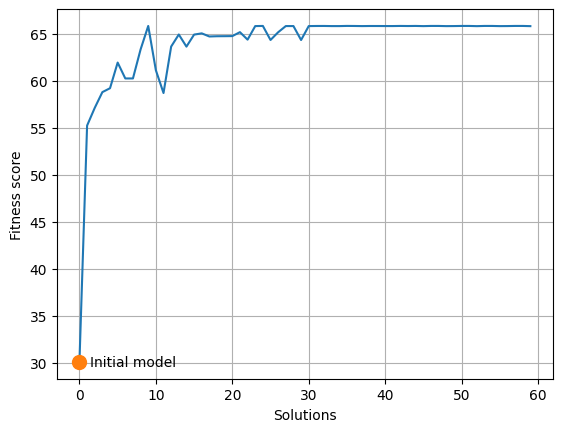

In [42]:
finals = [first_point, 55.25242995445439, 57.13970439812032, 58.81939811811676,59.23461108657314,61.967619689667096,60.27584294998154,60.27584294998154, 63.36781941511117, 65.86913147186759, 61.148863205939676,  58.721647741680236, 63.67331047729245, 64.959186480104,63.66773539955882, 64.94853023237607,65.08098774992239, 64.74792913403094, 64.77443141761778,64.78037036455127,64.78888181917547,65.20832777561597,64.40975850288429,65.85594115650558,65.87083585614357, 64.37403070634699, 65.19900351266315, 65.85751128358532,65.85792660461294,64.37160975203716, 65.85555378132659,65.8660751891534, 65.8685222907024,65.85594115650558, 65.855198879114,  65.87312987253034, 65.8668360803718, 65.855198879114, 65.8646488731149,65.86362014821067,65.8598027393979, 65.85881576649645, 65.87094200838794, 65.86231504800406, 65.87094200838794,  65.85246991021131, 65.87083585614357,65.87030970271641,65.85246991021131,65.85788773406708,65.87094200838794,65.87094200838794,65.85013645335346,65.87083585614357, 65.87030970271641,65.85246991021131, 65.85788773406708, 65.87094200838794,65.87094200838794, 65.85013645335346]
finals_x = range(0, len(finals))
first_point = 30.068834268492516
plt.plot(finals_x, finals)
plt.plot(0, first_point, 'o', markersize = 10 )
plt.text(7, first_point, 'Initial model', horizontalalignment='center',
     verticalalignment='center')
plt.grid()
plt.xlabel("Solutions")
plt.ylabel("Fitness score")

In [53]:
gen_mean =[]
for i in range(len(finals)) :
    if i% 10 ==0:
        gen_mean.append(np.mean(finals[i:i+10]))
gen_mean.insert(0, first_point)

Text(0, 0.5, 'fitness score')

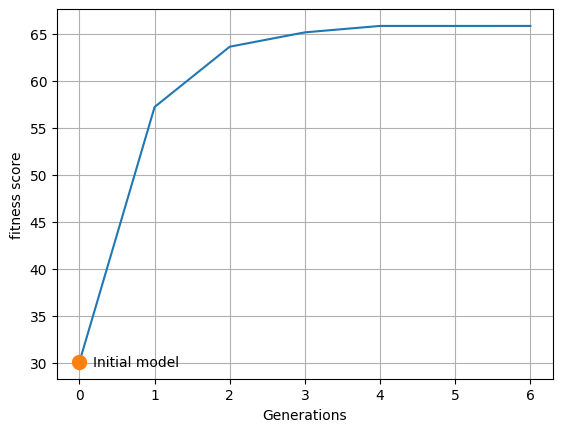

In [59]:
finals_xx = range(0, len(gen_mean))


plt.plot(finals_xx, gen_mean)

plt.plot(0, first_point, 'o', markersize = 10 )
plt.text(0.75, first_point, 'Initial model', horizontalalignment='center',
     verticalalignment='center')
plt.grid()
plt.xlabel("Generations")
plt.ylabel("fitness score")